# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2021

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


Αϊβαλής Θεόδωρος 03117099

Σαλιαράκης Παύλος 03117135

Λογω ενος προβληματος με το dataset και μετα απο επικοινωνια με τον κυριο Σιολα αντι για το dataset 52 πηραμε το 138 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd

dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 138

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"

df_data_2 = pd.read_csv(movie_seeds_url, header=None)
# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Call Me Claus']
['"Children\'s/Family",  "Family Drama",  "Holiday Film",  "Christmas movie",  "Drama",  "Family Film"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [ ]:
!pip install names-dataset
from names_dataset import NameDataset
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords_english
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import numpy as np
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import collections

#download the omportant tokenizers
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet') 
nltk.download('rslp')
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Θα αφαιρέσουμε όλα τα ονόματα από τις περιγραφές ταινιών καθώς και ορισμένες λέξεις που χρησιμοποιούνται συχνά στην περιγραφή ταινιών όπως π.χ. movie, film, plot etc που δεν είναι χαρακτηριστικά που διαφοροποιούν τη μια ταινία από την άλλη.

In [ ]:
m = NameDataset()
movie_words = ["movie", "film", "plot", "begins", "opens", "starts", "piece", "named", "woman", "women", "man", "men", "prologue", "help", "helping"]
stop_words = []
for i in range(5000):
    title = word_tokenize(corpus[i])
    titlecopy = []
    for word in title:
        if (m.search_first_name(word) or m.search_last_name(word) ) and word not in stop_words:
            stop_words.append(word)

In [ ]:
stop = list(stop_words) + list(movie_words)

## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf_plain = vectorizer.transform(corpus)

In [ ]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., '巴蘭社頭目寫了半個月', '賽德克巴萊之荷歌社頭目', '這次希望能不要超過'],
      dtype=object)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
print(corpus_tf_idf_plain.shape)
print(type(corpus_tf_idf_plain))
print(corpus_tf_idf_plain)

(5000, 48706)
<class 'scipy.sparse.csr.csr_matrix'>
  (0, 48366)	0.018934650317108868
  (0, 48242)	0.010139748662343677
  (0, 47910)	0.012728327021638983
  (0, 47899)	0.01113899656686699
  (0, 47776)	0.01763808756526771
  (0, 47753)	0.07449205686074899
  (0, 47727)	0.030267807143710357
  (0, 47615)	0.0167242185669399
  (0, 47481)	0.030267807143710357
  (0, 47443)	0.023349340882412674
  (0, 47440)	0.022766560492160103
  (0, 47425)	0.024606883470258478
  (0, 47408)	0.010135577822246432
  (0, 47118)	0.022088694909334797
  (0, 47087)	0.007836675334246609
  (0, 47063)	0.03335665061399506
  (0, 46982)	0.2732085868390367
  (0, 46945)	0.09854408933083286
  (0, 46744)	0.030267807143710357
  (0, 46667)	0.013730151585043444
  (0, 46348)	0.02724914017580266
  (0, 46156)	0.022645322960633967
  (0, 45934)	0.01935651344665021
  (0, 45707)	0.006922454472160306
  (0, 45440)	0.03284802977694429
  :	:
  (4999, 30337)	0.03150019760394943
  (4999, 29763)	0.37228142686994686
  (4999, 29698)	0.07982074710867

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


Αρχικά δοκιμάζουμε να δούμε τις προτασεις για την ταινια μηδεν. 
Είναι η 'The Muppets' που ανήκει στις εξής κατηγορίες: 
"Music",  "Family Film",  "Children\'s",  "Comedy",  "Musical"

Οι ταινίες που επιστρέφονται ως προτάσεις είναι από τις εξής κατηγορίες:
"Short Film", "Romantic drama",  "Romance Film",  "Drama", "Romantic comedy",  "Screwball comedy",  "Black-and-white",  "Western",  "Comedy",  "Romance Film","Children\'s/Family",  "Musical",  "Fantasy",  "Family Film"

Βλέπουμε δηλαδή ότι οι προτάσεις είναι από ίδιες ή παρόμοιες κατηγορίες με την ταινία στόχο μας.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(target_movie,max_recommendations,corpus_type):
    cos = cosine_similarity(corpus_type[target_movie],corpus_type).reshape(5000)
    print(target_movie,titles[target_movie],categories[target_movie],corpus[target_movie])
    indexes = np.argsort(cos)[::-1]
    for movie in range(max_recommendations):
        index = indexes[movie+1]
        print(movie+1, index, round(cos[index],4), titles[index],categories[index] ,corpus[index])
    return

content_recommender(0,5,corpus_tf_idf_plain)

0 ['The Muppets'] ['"Music",  "Family Film",  "Children\'s",  "Comedy",  "Musical"']  Walter lives with his human brother Gary in Smalltown. They became Muppet fans when they watched The Muppet Show in their youth. Gary plans a vacation to Los Angeles with his girlfriend, Mary to celebrate their tenth anniversary, inviting Walter along so he can tour the Muppet Studios. Mary feels that Gary's devotion to Walter is detracting from their relationship. In Los Angeles, the three visit the abandoned Muppet studio. During the tour, Walter sneaks into Kermit the Frog's office and discovers Statler and Waldorf selling the theater to Tex Richman, an oil magnate, and his henchmen Bobo the Bear and Uncle Deadly. Waldorf explains that if the Muppets can raise $10&nbsp;million they can repurchase the theater. After Statler and Waldorf leave the office, Walter overhears Richman revealing his plans to destroy the Muppet Theater and drill for oil underneath, and later warns Gary and Mary about Richman

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




Για την βελτιστοποιήση της δομής Tf-idf χρησιμοποιούμε μερικές από τις built-in παραμέτρους της υλοποίησης Tf-idf του scikit learn:

max_df (άνω φράγμα ποσοστού εμφάνισης μιας λέξης πέραν το οποίου η λέξη δεν υπολογίζεται) 

max_features (μέγιστος αριθμός χαρακτηριστικών στο τέλος της διεργασίας)

min_df = (ελάχιστος αριθμός εμφανίσεων μιας λέξης ώστε να συμπεριληφθεί στην ανάλυση)

stop_words = (λέξεις που επιθυμούμε να αγνοήσουμε με βάση το preproccesssing)

In [ ]:
def tf_idf(corpus):
    vectorizer = TfidfVectorizer(sublinear_tf = True, max_df=.5, min_df = 10, stop_words = stop)
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus)
    return corpus_tf_idf

corpus_tf_idf = tf_idf(corpus)
print(corpus_tf_idf.shape)
print(type(corpus_tf_idf))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aaan', 'aachen', 'aadesh', 'aadhi', 'aah', 'aakash', 'aaliyah', 'aam', 'aamina', 'aana', 'aar', 'aardvark', 'aaron', 'aarons', 'aarti', 'aatma', 'aayush', 'aazam', 'abagail', 'abarai', 'abba', 'abbas', 'abbes', 'abbess', 'abbey', 'abbie', 'abbott', 'abby', 'abbé', 'abdelaziz', 'abdelkader', 'abdellatif', 'abdenour', 'abdul', 'abdullah', 'abduls', 'abe', 'abedin', 'abel', 'abellard', 'abercromby', 'abhay', 'abhi', 'abhilash', 'abhimanyu', 'abhinaya', 'abhiram', 'abhirami', 'abid', 'abida', 'abigail', 'abilene', 'abimanyu', 'abin', 'abirami', 'abishi', 'abkari', 'abner', 'abolhassan', 'abou', 'abraham', 'abram', 'abrams', 'abruzzi', 'absalon', 'abu', 'abubakar', 'abyssinian', 'accel', 'accio', 'accra', 'achama', 'achamma', 'acharya', 'achille', 'achilles', 'achuta', 'achuthan', 'achyuta', 'ack

(5000, 7185)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
content_recommender(1369, 10, corpus_tf_idf)

1369 ['Athirathram'] ['"Crime Fiction",  "Action",  "Drama",  "Bollywood"'] Tharadas is a ruthless smuggler whose uncle was murdered by Rajesh. Rajesh is married to Thulasi who has dark past with Tharadas. Tharadas's cousin kills Rajesh and accuses Tharadas of the murder. Rajesh's partner Prasad and Thulasi get revenge on Tharadas, and Tharadas kills Chandu in turn. This film broke several Box Office Records and was the 3rd highest grosser in 1984. 
1 4781 0.1373 ['Shyness Machine Girl'] ['"Thriller",  "Science Fiction",  "Japanese Movies",  "Short Film",  "Horror",  "Action"'] Ami's friend, Yoshie, was murdered and desecrated by the Kimura Gang. She was saved and, like Ami in the previous film, received modifications from the same mechanics. Remembering her past, Yoshie decides to avenge herself and Ami.
2 3545 0.1369 ['Silver Lode'] ['"Action/Adventure",  "Western"'] The film, with a similar plot to High Noon, tells the story of Dan Ballard ([[John Payne  and Rose Evans  who are abou

In [ ]:
content_recommender(85, 9, corpus_tf_idf)

85 ['Docking the Boat'] ['"Romance Film",  "Drama",  "Comedy"'] A group of friends are to celebrate the summer on a small island in the Stockholm Archipelago. The plan is to eat crayfish and drink snaps, a quintessentially Swedish tradition. Some are already in the house on the island  and the rest of the group arrives by boat , but they experience great difficulties while trying to come ashore. Their only neighbor on the island, an eccentric, Hollywood-obsessed, hot-tempered hermit doesn't make the situation better.
1 2210 0.2215 ['Barnens Ö'] ['"Family Film",  "Drama"'] The story is set in Stockholm where 11-year old Reine is on the verge of puberty and afraid of sexual maturity. He lives in a suburb with his single mother who sends him to a traditional Swedish summer camp . His mother then vacations on her own, but in fact Reine never goes to the camp, instead exploring the summer city of Stockholm on his own, meeting many strange adults.
2 650 0.2056 ['Pojkarna på Storholmen'] ['"C

In [ ]:
content_recommender(42, 5, corpus_tf_idf)

42 ['Top Dog'] ['"Action/Adventure",  "Crime Fiction",  "Action",  "Thriller",  "Comedy"'] The film opens as two white nationalists destroy an apartment complex in which most of the residents are minorities. A veteran police officer and his police dog, Reno, investigate the crime and realize the explosives are military in style. Their investigation takes them to the harbor, where they find a ship loaded with weapons. They are discovered and shot; the officer dies, but Reno survives. Maverick cop Jake Wilder , who is suspended from duty, is called by police captain Ken Callahan , who requests Wilder to take over the case. Wilder is angered that he has to work with Reno, despite Reno proving himself capable through a battle training scenario. Meanwhile, Neo-Nazis are trying to smuggle weapons across the border from Mexico. It is implied that they murdered their Mexican arms dealers. They are stopped by the Border Patrol and try to escape, but their car is destroyed in the process. Wilder

In [ ]:
content_recommender(999, 8, corpus_tf_idf)

999 ['Call Me Claus'] ['"Children\'s/Family",  "Family Drama",  "Holiday Film",  "Christmas movie",  "Drama",  "Family Film"']  The movie starts as a flashback to Lucy Collins as a little girl. Her mother takes the kids to see a shopping mall Santa Claus, who happens to be the real one. Santa is nearing the end of his 200 year reign as St. Nick, and needs to find a replacement, someone who enjoys the Christmas season and it is shown from the heart. His search involves his hat and an elf assistant named Ralph . Nick puts the hat on every kid. If the hat glows, it means that person has the real Christmas spirit. He sees a lot of kids, and none of them glow. When Lucy sits on his lap, he puts the hat on her and it glows brightly, proving she'd make a good new Santa Claus, though&mdash;in this flashback&mdash;his reign still has 30–40 years to go. The movie returns to present day. It is Nick's last Christmas as Santa, and he must find Lucy again. He locates her in Los Angeles where she wor

Βλέπουμε ενα παράδειγμα καλων προτάσεων για την ταινία 85('Docking the Boat')  που πρόκειται για "Romance Film",  "Drama",  "Comedy" και οι ταινιες που προτείνουμε είναι κυριως ρομαντικες, κομικες και δραματικες. 
Ομοια πολυ καλα αποτελέσματα παιρνουμε και για την ταινία 999('Call Me Claus').


Ένα παράδειγμα κακών προτάσεων είναι για την ταινία 42 ('Top Dog') που πρόκειται για "Action/Adventure",  "Crime Fiction",  "Action",  "Thriller",  "Comedy" και σαν προτάσεις έχουμε '"Parody",  "Science Fiction",Biographical film","Comedy film" τα οποια είναι τελείως ασυσχέτιστα μεταξύ τους.

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
!pip install -U gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

     |████████████████████████████████| 24.1 MB 57.1 MB/s            
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

Αρχικά κατεβάζουμε απο το αποθετήριο τα μοντέλα εμφυτευμάτων οπως φαίνεται παρακάτω.

In [ ]:
w2v_model = gensim.downloader.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


Ουσιαστικά το συνολικό διάνυσμα W2V(d) προκύπτει ως εννα αθροισμα των επιμέρους γινομένων των διανυσμάτων κάθε λέξης με τον αντίστοιχο συντελεστή βάρους από το εμφύτευμα(τα προεπεξεργασμένα δεδομένα) δια το αρχικό άθροισμα(χωρίς τα βαρη).

#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
print(type(corpus))
print(type(corpus_tf_idf))
print(type(corpus_tf_idf_plain))
idfs = idf_all(corpus)

<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


(Η παρακάτω συνάρτηση εν τέλει δεν λειτουργει απλα εξηγούμε την λειτουργία)

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
    new_corpus = np.zeros((len(corpus), embeddings_size))
    for i in range(len(corpus)):
        A = 0
        for j in range(len(corpus[i])):
            if corpus[i][j] not in vectors or corpus[i][j] not in x:
                a=0
            else:
                a = tf_idf[i][x.index(corpus[i][j])]*vectors[corpus[i][j]]
            A += a            #εδω δημιουργούμε τον αριθμητή
        B = sum(tf_idf[i])    #και εδω τον παρανομαστη
        new_corpus[i] = A/B   #και κάνουμε το κλασμα
    return new_corpus    

In [ ]:
import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

['corpus_tf_idf.pkl']



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

total 6.4M
-rw-r--r-- 1 root root    0 Dec 17 07:46 10x10som.pkl
-rw-r--r-- 1 root root 6.4M Dec 17 07:48 corpus_tf_idf.pkl
drwx------ 5 root root 4.0K Dec 17 07:46 drive
drwxr-xr-x 1 root root 4.0K Dec  3 14:33 sample_data


και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return np.array(final_set, dtype=np.float32)

Με τη βελτιστοποίηση που κάναμε εχουμε μειωση των χαρακτηριστικων σε 7500 περιπου και χωρις αυτη θα ειχαμε πολλαπλασια.

In [ ]:
final_set = build_final_set(corpus_tf_idf)
print(final_set.shape)
print(corpus_tf_idf.shape)

(5000, 7507)
(5000, 7185)


Και επίσης τυπώνουμε τις μη μηδενικες τιμες ενός από τα στοιχεία του final_set.

In [ ]:
for i in range(len(final_set[0])):
    if final_set[0][i]!=0:
        print(final_set[0][i])

0.049816363
0.04606642
0.037594106
0.07340758
0.04380228
0.030280644
0.04009485
0.03266811
0.02503198
0.10225767
0.050643187
0.095952556
0.108875036
0.030214796
0.05690345
0.04752346
0.023357667
0.052989233
0.019716702
0.11196916
0.050453745
0.031522416
0.02517514
0.037390508
0.02557258
0.037526872
0.08614374
0.06967398
0.033532728
0.061544955
0.039449222
0.053083383
0.032496594
0.05439313
0.17172152
0.042980175
0.052989233
0.06430335
0.048886843
0.05832011
0.04284274
0.084955074
0.049468774
0.04638028
0.11594005
0.029157776
0.03655731
0.09720091
0.0723162
0.05537057
0.07852864
0.05113228
0.06502872
0.053230934
0.073095344
0.036810663
0.026994104
0.05812359
0.0680533
0.059809368
0.05196548
0.04085783
0.045701746
0.027574312
0.11522425
0.05812359
0.041886296
0.05363
0.04393559
0.0405973
0.0680533
0.068566255
0.12006497
0.23382626
0.06430335
0.037946913
0.035487205
0.055050343
0.05793067
0.02691377
0.065411076
0.08706417
0.124122694
0.022364693
0.033420682
0.040271554
0.054123536
0.05684

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

Εχουμε φτιάξει τους εξής 3 χαρτες (5x5,10x10,20x20) οι οποίοι υπάρχουν και στο αρχείο υποβολής.

In [ ]:
n_rows, n_columns = 5,5
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = '5x5som.pkl'

In [ ]:
%time som.train(final_set, epochs=epochs)
joblib.dump(som, filename) 

CPU times: user 4min 35s, sys: 1.52 s, total: 4min 37s
Wall time: 2min 31s


['5x5som.pkl']

In [ ]:
n_rows, n_columns = 10,10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = '10x10som.pkl'

In [ ]:
%time som.train(final_set, epochs=epochs)
joblib.dump(som, filename) 

CPU times: user 19min 9s, sys: 5.23 s, total: 19min 14s
Wall time: 10min


['10x10som.pkl']

In [ ]:
n_rows, n_columns = 20,20
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
epochs = 100
filename = '20x20som.pkl'

In [ ]:
%time som.train(final_set, epochs=epochs)
joblib.dump(som, filename) 

CPU times: user 1h 20min 54s, sys: 20.9 s, total: 1h 21min 15s
Wall time: 41min 30s


['20x20som.pkl']

Εχουμε επισυνάψει παρακάτω του χρόνους εκπαίδευσης για τους 3 χάρτες μας. Βλέπουμε ότι καθώς μεγαλώνει ο χαρτής αυξάνεται σημαντικά ο χρονος για την εκπαιδευση.

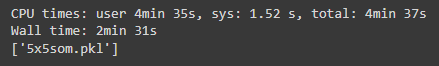


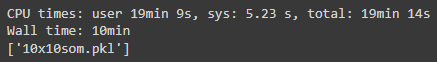

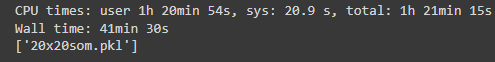

In [ ]:
import joblib
som5 = joblib.load('5x5som.pkl')
som10 = joblib.load('10x10som.pkl')
som20 = joblib.load('20x20som.pkl')


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


Αρχικα έχουμε τα bmus για τον χαρτη 5x5.

In [ ]:
bmus5 = som5.bmus
print(bmus5.shape)
print(bmus5)
ubmus5, indices5 = np.unique(bmus5, return_inverse=True, axis=0)

(5000, 2)
[[1 3]
 [0 2]
 [0 1]
 ...
 [1 1]
 [1 0]
 [4 0]]


In [ ]:
print(ubmus5[:100].shape)
print(ubmus5[:100])

(25, 2)
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]]


In [ ]:
print(len(indices5))
print(indices5)
print(np.where(indices5==0))

5000
[ 8  2  1 ...  6  5 20]
(array([  31,   38,   39,   50,   81,  111,  115,  120,  126,  130,  134,
        159,  165,  196,  216,  241,  281,  288,  307,  355,  366,  454,
        467,  473,  494,  515,  554,  560,  571,  573,  612,  655,  659,
        686,  723,  724,  736,  738,  746,  754,  925,  964,  967, 1031,
       1055, 1104, 1122, 1155, 1161, 1173, 1191, 1258, 1274, 1386, 1397,
       1421, 1442, 1451, 1509, 1513, 1518, 1525, 1540, 1549, 1552, 1562,
       1579, 1657, 1679, 1680, 1695, 1753, 1762, 1773, 1839, 1849, 1927,
       1946, 2006, 2017, 2078, 2116, 2127, 2146, 2158, 2201, 2242, 2367,
       2384, 2442, 2470, 2519, 2544, 2593, 2598, 2615, 2622, 2644, 2673,
       2724, 2746, 2811, 2824, 2884, 2909, 2912, 2939, 2967, 2968, 2976,
       2988, 2995, 3023, 3033, 3047, 3079, 3131, 3159, 3218, 3249, 3258,
       3273, 3306, 3331, 3362, 3421, 3483, 3491, 3523, 3556, 3565, 3600,
       3624, 3628, 3641, 3652, 3677, 3716, 3722, 3742, 3747, 3756, 3791,
       3819, 3835, 38

Τα bmus για τον χάρτη 10x10.

In [ ]:
bmus10 = som10.bmus
print(bmus10.shape)
print(bmus10)
ubmus10, indices10 = np.unique(bmus10, return_inverse=True, axis=0)

(5000, 2)
[[3 2]
 [0 0]
 [4 5]
 ...
 [8 9]
 [9 7]
 [8 1]]


In [ ]:
print(ubmus10[:100].shape)
print(ubmus10[:100])

(97, 2)
[[0 0]
 [0 1]
 [0 2]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 3]
 [2 4]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [2 9]
 [3 0]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [5 9]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 7]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 2]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]


In [ ]:
print(len(indices10))
print(indices10)
print(np.where(indices10==0))

5000
[30  0 43 ... 86 94 78]
(array([   1,   91,  124,  166,  178,  207,  221,  236,  417,  435,  445,
        510,  529,  742,  762,  768,  774,  775,  788,  879,  912,  968,
        993, 1057, 1061, 1114, 1169, 1237, 1296, 1300, 1383, 1390, 1393,
       1423, 1661, 1703, 1713, 1897, 1950, 2018, 2056, 2066, 2115, 2288,
       2323, 2353, 2416, 2501, 2913, 2919, 2924, 2932, 3007, 3098, 3126,
       3188, 3225, 3261, 3262, 3265, 3269, 3361, 3423, 3471, 3516, 3549,
       3570, 3734, 3743, 3770, 3841, 3850, 3863, 3870, 3913, 3990, 4088,
       4235, 4281, 4317, 4318, 4376, 4581, 4596, 4606, 4732, 4821, 4928]),)


Τα bmus για το χαρτη 20x20.

In [ ]:
bmus20 = som20.bmus
print(bmus20.shape)
print(bmus20)
ubmus20, indices20 = np.unique(bmus20, return_inverse=True, axis=0)

(5000, 2)
[[14 10]
 [19 19]
 [10  6]
 ...
 [10  1]
 [ 6  0]
 [ 2 17]]


In [ ]:
print(ubmus20[:100].shape)
print(ubmus20[:100])

(100, 2)
[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  6]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 2  9]
 [ 2 12]
 [ 2 13]
 [ 2 15]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 19]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  8]
 [ 4  9]
 [ 4 10]
 [ 4 11]
 [ 4 14]
 [ 4 15]
 [ 4 16]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 14]
 [ 5 17]]


In [ ]:
print(len(indices20))
print(indices20)
print(np.where(indices20==0))

5000
[253 343 178 ... 174 102  50]
(array([  82,  180,  187,  460,  536,  756,  803,  808,  877,  909, 1163,
       1204, 1229, 1333, 1392, 1394, 1542, 1606, 1616, 1734, 1901, 1905,
       1919, 2057, 2101, 2164, 2572, 2699, 2734, 3067, 3171, 3233, 3268,
       3380, 3401, 3503, 3548, 3667, 3950, 4011, 4027, 4260, 4296, 4392,
       4446, 4508, 4578, 4785, 4960]),)



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


Κάνουμε τη διαδικασία του clustering και για τους 3 χάρτες. 

In [ ]:
from sklearn.cluster import KMeans
n_cluster = 25
algorithm = KMeans(n_clusters=n_cluster)
som5.cluster(algorithm=algorithm)
som10.cluster(algorithm=algorithm)
som20.cluster(algorithm=algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
n_rows, n_columns = 5,5
epochs = 100
filename = 'som_5_' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'
joblib.dump(som5, filename, compress = True)

n_rows, n_columns = 10,10
filename = 'som_10_' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'
joblib.dump(som10, filename, compress = True)

n_rows, n_columns = 20,20
filename = 'som_20_' + str(n_rows) + 'x' + str(n_columns) + '@' + str(epochs) + 'e.pkl'
joblib.dump(som20, filename, compress = True)

['som_20_20x20@100e.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



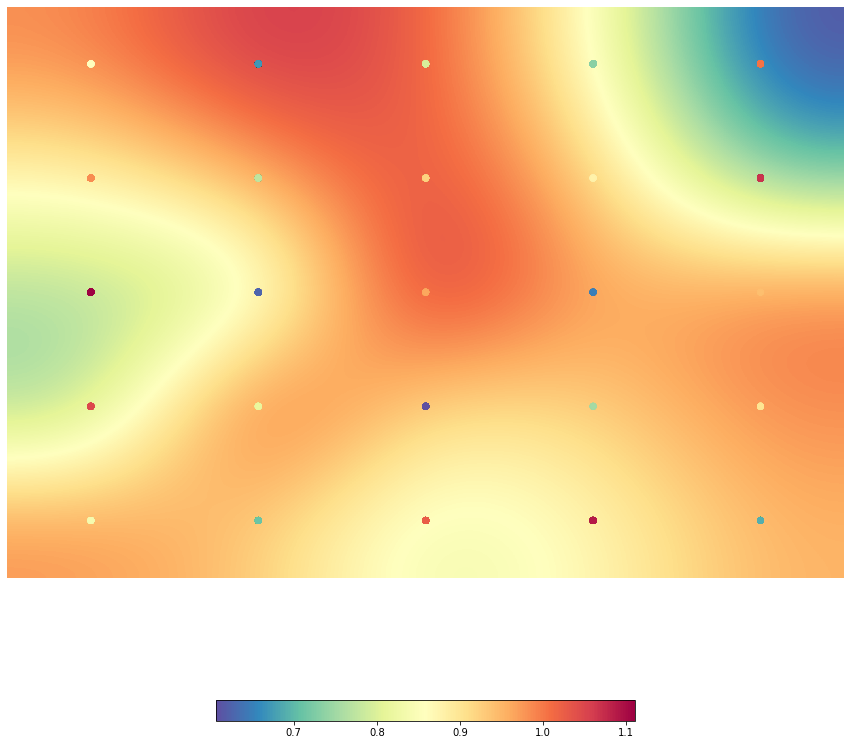

[[12  3  9  6 19]
 [18  8 15 13 22]
 [24  1 17  2 16]
 [21 10  0  7 14]
 [11  5 20 23  4]]
Cluster Index:
[ 0 22 21 20 19 18 17 16 15 14 13 23 12 10  9  8  7  6  5  4  3  2  1 11
 24]
Number of Neurons:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
som5.view_umatrix(bestmatches=True, colorbar=True, figsize=(15,15))
print(som5.clusters)
_ , no_of_neurons = np.unique(som5.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

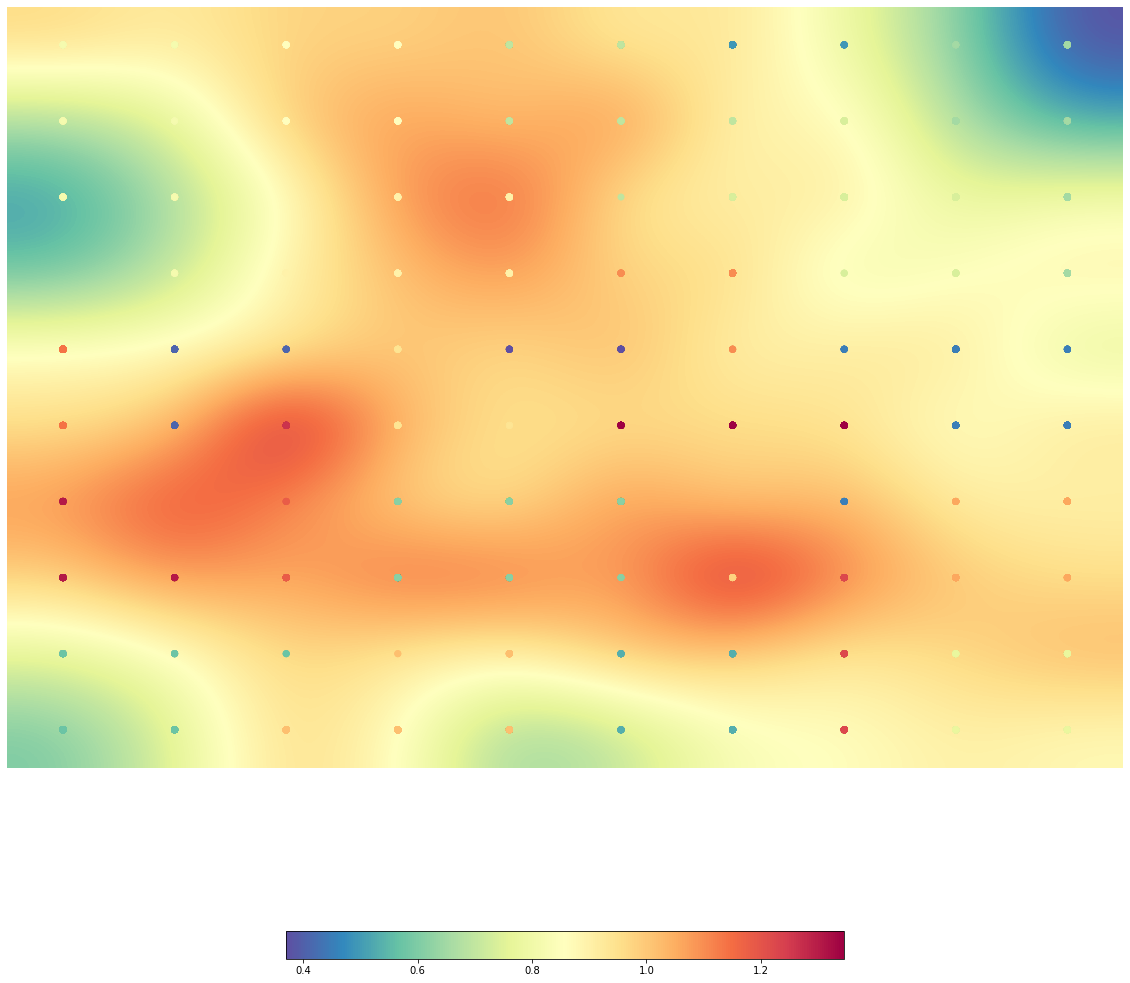

[[11 11 12 12  8  8  3  3  7  7]
 [11 11 12 12  8  8  8  9  7  7]
 [11 11 11 13 13  8  9  9  9  7]
 [11 11 13 13 13 18 18  9  9  7]
 [19  1  1 14  0  0 18  2  2  2]
 [19  1 22 14 14 24 24 24  2  2]
 [23 19 20  6  6  6 24  2 17 17]
 [23 23 20  6  6  6 15 21 17 17]
 [ 5  5  5 16 16  4  4 21 10 10]
 [ 5  5 16 16 16  4  4 21 10 10]]
Cluster Index:
[22 15  0  3 20  1 21 19 18 14 23 17 12 10  4 24 13 16  5  9  8  7  6  2
 11]
Number of Neurons:
[1 1 2 2 2 3 3 3 3 3 3 4 4 4 4 4 5 5 5 6 6 6 6 6 9]


In [ ]:
som10.view_umatrix(bestmatches=True, colorbar=True, figsize=(20,20))
print(som10.clusters)
_ , no_of_neurons = np.unique(som10.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])

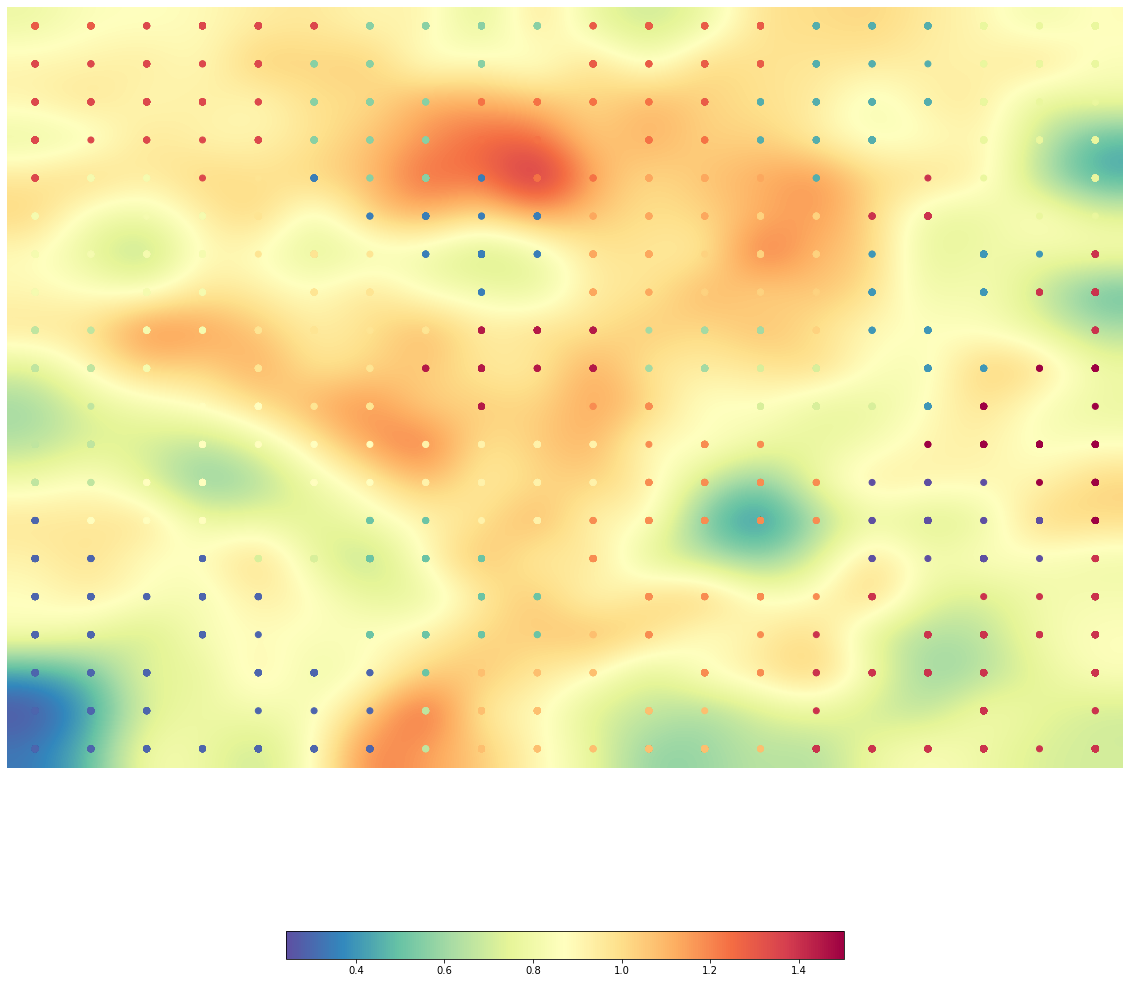

[[20 20 21 21 21 21  6  6  6  6 20 20 20 20  4  4  4 10 10 10]
 [21 21 21 21 21  6  6  6  6  6 20 20 20 20  4  4  4 10 10 10]
 [21 21 21 21 21  6  6  6 19 19 19 19 20  4  4  4  4 10 10 10]
 [21 21 21 21 21  6  6  6 19 19 19 19 19  4  4  4  4 10 10 10]
 [21 11 11 21 14  2  6  6  2 19 19 17 17 17  4  4 22 10 10 10]
 [11 11 11 11 14 14  2  2  2  2 17 17 17 15 15 22 22  3 10 10]
 [11 11 11 11 14 14 14  2  2  2 17 17 15 15 15  3  3  3  3 22]
 [11 11 11 11 14 14 14  2  2  2 17 17 15 15 15  3  3  3 22 22]
 [ 8  8 11 11 14 14 14 14 23 23 23  7  7  7 15  3  3  3 22 22]
 [ 8  8 11 12 14 14 14 23 23 23 23  7  7  9  9  3  3  3 24 24]
 [ 8  8 12 12 12 14 14 23 23 13 18 18 18  9  9  9  3 24 24 24]
 [ 8  8 12 12 12 12 12 13 13 13 13 18 18 18  9  9 24 24 24 24]
 [ 8  8 12 12 12 12 12 13 13 13 13 18 18 18 18  0  0  0 24 24]
 [ 1 12 12 12 12  5  5  5 13 13 18 18 18 18 18  0  0  0  0 24]
 [ 1  1  1  1  9  9  5  5  5 18 18 18 18 18 18  0  0  0  0 22]
 [ 1  1  1  1  1  9  5  5  5  5 18 18 18 18 18 22 22 22

In [ ]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(20,20))
print(som20.clusters)
_ , no_of_neurons = np.unique(som20.clusters, return_counts=True)
cluster_index = np.argsort(no_of_neurons)
print("Cluster Index:")
print(cluster_index)
print("Number of Neurons:")
print(no_of_neurons[cluster_index])


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(movie_list):
    total_categories = []
    for movie in movie_list:
        categs = categories[movie][0]
        categs = categs.split(',')
        for number_of_categs in categs:
            number_of_categs = number_of_categs.strip(' ')
            number_of_categs = number_of_categs.strip('"')
            total_categories.append(number_of_categs)
    total_categories = np.unique(total_categories,return_counts=True)
    inds = np.argsort(total_categories[1])[::-1]
    answer = []
    for index in inds:
        answer.append((total_categories[0][index],total_categories[1][index]))
    print(answer)
    return

Ορίζουμε την συνάρτηση print_categories_stats που επιστρέφει για ένα σύνοο ταινιών ομαδοποιημένες τις κατηγορίες των ταινιών.

In [ ]:
print_categories_stats([i for i in range(5000)])

[('Drama', 2260), ('Comedy', 1242), ('Thriller', 827), ('Romance Film', 750), ('Action', 700), ('World cinema', 557), ('Horror', 512), ('Crime Fiction', 508), ('Black-and-white', 475), ('Indie', 435), ('Action/Adventure', 425), ('Short Film', 401), ('Adventure', 400), ('Family Film', 382), ('Science Fiction', 305), ('Musical', 300), ('Romantic drama', 284), ('Animation', 271), ('Mystery', 245), ('Romantic comedy', 242), ('Fantasy', 238), ('Comedy film', 206), ('Crime Thriller', 201), ('War film', 161), ('Silent film', 159), ('Comedy-drama', 147), ('Psychological thriller', 144), ('Japanese Movies', 144), ('Western', 142), ('Period piece', 142), ('Bollywood', 134), ('Film adaptation', 126), ('Documentary', 123), ('Chinese Movies', 100), ('Parody', 100), ('Slasher', 93), ('Black comedy', 90), ('Teen', 89), ("Children's/Family", 87), ('Martial Arts Film', 84), ('Family Drama', 83), ('Cult', 83), ('Coming of age', 81), ('Biographical film', 78), ('Suspense', 78), ('Television movie', 77), 

In [ ]:
def print_cluster_neurons_movies_report(cluster_index):
    neurons_number = no_of_neurons[cluster_index]
    positions = np.where(som20.clusters == cluster_index)
    stack_positions = np.column_stack((positions[0],positions[1]))
    inds = []
    for position in stack_positions:
          if position in bmus20:
              inds.append(int(position[0]) * n_rows + int(position[1]))
    return inds

Εχουμε την συνάρτηση print_cluster_neurons_movies_report η οποία εμφανίζει για ένα cluster τους νευρώνες που ανήκουν σε αυτό.

In [ ]:
print_cluster_neurons_movies_report(1)

[260,
 280,
 281,
 282,
 283,
 300,
 301,
 302,
 303,
 304,
 320,
 321,
 322,
 323,
 324,
 325,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 380,
 381,
 382,
 383,
 384,
 385,
 386]

In [ ]:
def neuron_movies_report(neuron_list):
    neuron_movies = []
    for neuron_id in neuron_list:
        temporary_array = np.where(indices20 == neuron_id)
        for i in range(temporary_array[0].shape[0]):
            neuron_movies.append(temporary_array[0][i])
    print_categories_stats(neuron_movies)

Τέλος την neuron_movies_report που με βοήθεια τις άλλες δυο τυπώνει τις πληθικότητες των κατηγοριών εντός ενός cluster.

In [ ]:
for i in list(cluster_index):
  print()
  print("Cluster ID" , i)
  print()
  neuron_movies_report(print_cluster_neurons_movies_report(i))


Cluster ID 7

[('Romance Film', 27), ('Drama', 27), ('Comedy', 27), ('Romantic comedy', 27), ('Thriller', 13), ('Romantic drama', 9), ('Disaster', 6), ('Action/Adventure', 6), ('Musical', 5), ('Science Fiction', 5), ('Film adaptation', 5), ('Adventure', 5), ('Costume drama', 4), ('Screwball comedy', 3), ('Black-and-white', 3), ('Period piece', 3), ('Music', 2), ('World cinema', 2), ('Comedy of manners', 2), ('Spy', 2), ('Crime Fiction', 2), ('Biopic [feature]', 1), ('Bollywood', 1), ('Coming of age', 1), ('Backstage Musical', 1), ('Biography', 1), ('Black comedy', 1), ('Crime Comedy', 1), ('Zombie Film', 1), ('Horror Comedy', 1), ('Domestic Comedy', 1), ('Doomsday film', 1), ('Horror', 1), ('Indie', 1), ('Media Satire', 1), ('Parody', 1), ('Pre-Code', 1), ('Sex comedy', 1), ('Sports', 1), ('Supernatural', 1), ('Television movie', 1), ('Time travel', 1), ('Workplace Comedy', 1), ('Action Thrillers', 1)]

Cluster ID 15

[('Comedy', 80), ('Drama', 79), ('Comedy-drama', 50), ('Indie', 41)


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


1.Δεδομενα με μεγαλη πυκνοτητα

Ορίζουμε την συνάρτηση num_of_neurons_for_category η οποία μετρα σε πόσους νευρώνες εμφανίζεται μία κατηγορία. Όπως αναμένουμε η κατηγορίες Drama και Comedy που εφανίζονται στο μεγαλυτερο μέρος του dataset, κυριαρχούν σε πολλούς νευρώνες. Εν γένει η συμπεριφορά είναι ανάλογη, καθώς μειώνεται ο αριθμός ταινιών της εκάστοτε κατηγορίας μειώνονται και οι νευρώνες στους οποίους κυριαρχεί.

In [ ]:
def num_of_neurons_for_category(Category):
    num_of_neurons = 0
    # num_of_movies = 0
    for neuron in range(30 * 30):
        list_of_movies = list(np.where(indices20==neuron))
        total_categories = []
        for item in list_of_movies[0].tolist():
            categs = categories[item][0] 
            categs = categs.split(',')
            for number_of_categs in categs:
                number_of_categs = number_of_categs.strip(' ')
                number_of_categs = number_of_categs.strip('"')
                total_categories.append(number_of_categs)
        total_categories = np.unique(total_categories,return_counts=True)
        inds = np.argsort(total_categories[1])[::-1]
        
        for i in range(min(3,len(inds))):
            index = inds[i]
            if(total_categories[0][index] == Category):
                num_of_neurons += 1
                # num_of_movies += total_categories[1][index]
    print("Category",Category,"was found in",num_of_neurons, "neurons.")
    # print(num_of_movies)

In [ ]:
for category in ['Comedy','Drama','Action','Science Fiction','Musical','Black-and-white',"Bollywood","Computer Animation"]:
    num_of_neurons_for_category(category)

Category Comedy was found in 83 neurons.
Category Drama was found in 117 neurons.
Category Action was found in 49 neurons.
Category Science Fiction was found in 26 neurons.
Category Musical was found in 22 neurons.
Category Black-and-white was found in 24 neurons.
Category Bollywood was found in 7 neurons.
Category Computer Animation was found in 2 neurons.


2.Μακρυνα προτυπα εισόδου

Ορίζουμε την συνάρτηση plot_neurons_for_2_categories που υπολογίζει τους νευρώνες που ανήκουν σε μία από τις 2 κατηγορίες και με scatter plot παρουσιάζει την τοπολογία των 2 κατηγοριών. 

In [ ]:
import matplotlib.pyplot as plt

def plot_neurons_for_2_categories(Category1,Category2):
    num_of_neurons = 0
    categ_1_x = []
    categ_1_y = []
    categ_2_x = []
    categ_2_y = []
    for neuron in range(30 * 30):
        list_of_movies = list(np.where(indices20==neuron))
        total_categories = []
        for item in list_of_movies[0].tolist():
            categs = categories[item][0] 
            categs = categs.split(',')
            for number_of_categs in categs:
                number_of_categs = number_of_categs.strip(' ')
                number_of_categs = number_of_categs.strip('"')
                total_categories.append(number_of_categs)
        total_categories = np.unique(total_categories,return_counts=True)
        inds = np.argsort(total_categories[1])[::-1]
        
        for i in range(min(3,len(inds))):
            index = inds[i]
            if(total_categories[0][index] == Category1):
                [x,y] = list(ubmus20[neuron])
                categ_1_x.append(x)
                categ_1_y.append(y)
            if(total_categories[0][index] == Category2):
                [x,y] = list(ubmus20[neuron])
                categ_2_x.append(x)
                categ_2_y.append(y)
    plt.scatter(categ_1_x, categ_1_y, label = Category1, color = 'r', alpha = .3)
    plt.scatter(categ_2_x, categ_2_y, label = Category2, color = 'b', alpha = .3)
    plt.legend(loc = 'best')
    plt.title("Topology of Neurons for 2 Categories")
    plt.show()
    return

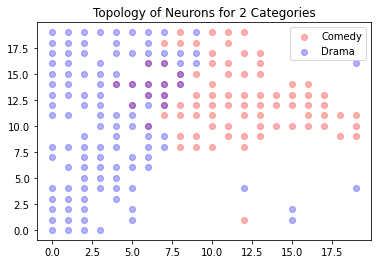

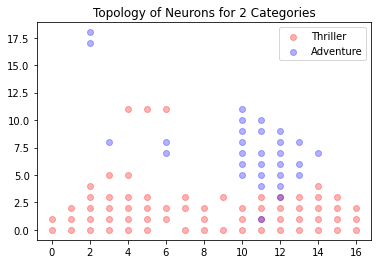

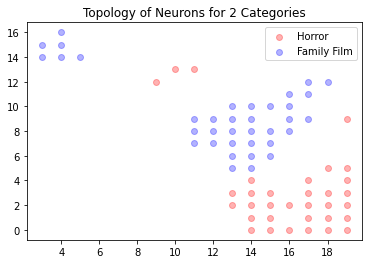

In [ ]:
plot_neurons_for_2_categories('Comedy','Drama')

plot_neurons_for_2_categories('Thriller','Adventure')

plot_neurons_for_2_categories('Horror','Family Film')

Αρχικώς προβάλουμε τα Drama και Comedy και παρατηρούμε οτι οι δύο μεγαλύτερες κατηγορίες καταλαμβάνουν πολύ μεγάλο χώρο στο χάρτη και κατέχουν αντιδιαμετρικές περιοχές πράγμα που υποδεικνύει πως η διαδικασία εκπαίδευσης ήταν επιτυχιμένη.

Στην συνέχεια εξετάζουμε και άλλες περιπτώσεις αντικρουόμενων κατηγοριών (Thriller, Adventure), (Family Film, Horror) και παρατηρούμε ότι πράγματι βρίσκονται σε διαφορετικές περιοχές τοπολογικά και δεν εμφανίζουν πολλούς κοινούς νευρώνες.

3.Κοντινα προτυπα εισοδου

Αρχικά εξετάζουμε περιπτώσεις υποκατηγοριών όπως Thriller και Psychological thriller όπου βλέπουμε μια ξεκάθαρη σχέση συνόλου - υποσυνόλου. Στην συνέχεια εξετάζουμε κοντινές νοηματικά κατηγορίες όπως (Horror,Thriller) και (Animation,Family film,Short Film) ο οποίες αποτυπώνονται στο SOM ως κοντινές περιοχές.

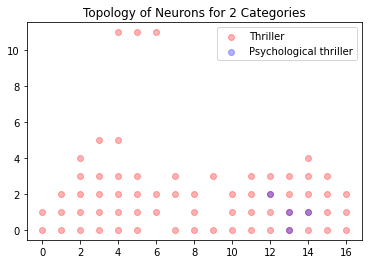

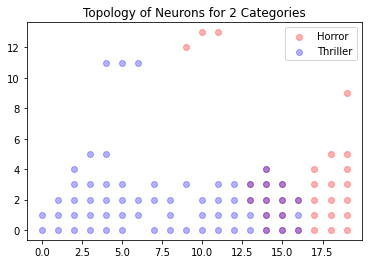

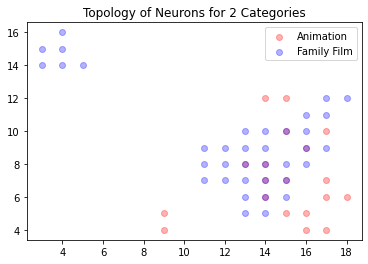

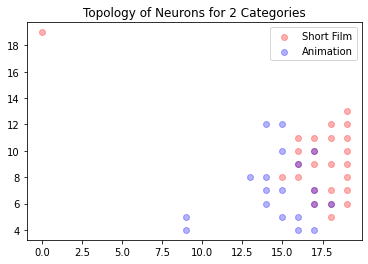

In [ ]:
plot_neurons_for_2_categories("Thriller", 'Psychological thriller')

plot_neurons_for_2_categories("Horror","Thriller")

plot_neurons_for_2_categories("Animation", "Family Film")

plot_neurons_for_2_categories("Short Film","Animation")

Αξιολογηση των clusters

Υπάρχουν clusters τα οποία είναι ποιοτικά και κάποια άλλα μη ποιοτικά

Για το cluster με id = 1 βλέπουμε ότι αποτελείται τόσο απο Animation, Comedy film, Documentaries Family films και Short films σε ποσοστα πολυ κοντινα μεταξυ τους. Άρα προκειται για ένα όχι και τόσο καλο cluster. 

In [ ]:
Cluster_ID = 1
print("Cluster ID" , Cluster_ID)
print()
neuron_movies_report(print_cluster_neurons_movies_report(Cluster_ID))

Cluster ID 1

[('Animation', 104), ('Comedy film', 97), ('Documentary', 88), ('Family Film', 83), ('Short Film', 79), ('Science Fiction', 58), ('Black-and-white', 53), ('Western', 51), ('Romance Film', 50), ('Horror', 49), ('Comedy', 36), ('Action/Adventure', 27), ('Indie', 17), ('Biography', 13), ('Musical', 12), ('Culture & Society', 11), ('Fantasy', 9), ('Drama', 9), ('History', 9), ('Creature Film', 8), ('Music', 8), ('Japanese Movies', 8), ('B-movie', 7), ('Political cinema', 7), ('Social issues', 7), ('Crime Fiction', 7), ('War film', 7), ('Sci-Fi Horror', 6), ('Zombie Film', 6), ('Monster movie', 5), ("Children's/Family", 5), ('World cinema', 5), ('Cult', 5), ('Television movie', 5), ('Adventure', 5), ('Sports', 5), ('Mystery', 4), ('Alien Film', 4), ('Film noir', 4), ('Stop motion', 4), ('Law & Crime', 3), ('Silent film', 3), ('Natural horror films', 3), ('Monster', 3), ('Biopic [feature]', 3), ('Comedy-drama', 2), ('Disaster', 2), ('Tragedy', 2), ('Tamil cinema', 2), ('Costume

Για το cluster με id = 10 βλέπουμε ότι αποτελείται σε συντριπτικη πλειοψηφία απο Dramas και σε μικροτερο ποσοστο απο Thriller(που ειναι σχετικα συγγενικο) και Romance.

In [ ]:
Cluster_ID = 10
print("Cluster ID" , Cluster_ID)
print()
neuron_movies_report(print_cluster_neurons_movies_report(Cluster_ID))

Cluster ID 10

[('Drama', 568), ('Thriller', 82), ('Romance Film', 57), ('Indie', 53), ('Mystery', 46), ('Comedy', 42), ('Crime Fiction', 35), ('World cinema', 33), ('Comedy film', 29), ('Action', 29), ('Short Film', 23), ('Action/Adventure', 22), ('War film', 19), ('Film adaptation', 17), ('Period piece', 15), ('Fantasy', 14), ('Adventure', 14), ('Family Film', 13), ('Psychological thriller', 10), ('Teen', 9), ('Musical', 9), ('Chinese Movies', 8), ('Romantic drama', 7), ('Western', 7), ('Documentary', 7), ('Art film', 7), ('Biographical film', 7), ('History', 6), ('Political drama', 6), ('Epic', 6), ('Crime Drama', 6), ('Japanese Movies', 6), ('Horror', 6), ('Crime Thriller', 6), ('Black-and-white', 5), ('Suspense', 5), ('Bollywood', 5), ('Historical fiction', 4), ('Ensemble Film', 4), ('Marriage Drama', 4), ('Melodrama', 4), ('Political thriller', 4), ('Coming of age', 4), ("Children's", 4), ('Revisionist Western', 3), ('Science Fiction', 3), ('Buddy film', 3), ('Biopic [feature]', 

Για το cluster με id = 14 βλέπουμε ότι αποτελείται κυρίως από Comediew, Action, Adventure, Indie, Parodies που πρόκειται για σχετικα κοντινές κατηγοριες.
Άρα πρόκειται για ποιοτικό cluster.

In [ ]:
Cluster_ID = 14
print("Cluster ID" , Cluster_ID)
print()
neuron_movies_report(print_cluster_neurons_movies_report(Cluster_ID))

Cluster ID 14

[('Comedy', 130), ('Action', 95), ('Action/Adventure', 89), ('Indie', 51), ('Crime Fiction', 43), ('Parody', 41), ('World cinema', 30), ('Martial Arts Film', 29), ('Romantic comedy', 27), ('Thriller', 25), ('Romance Film', 23), ('Western', 23), ('Horror', 22), ('Chinese Movies', 21), ('Cult', 19), ('Satire', 19), ('Drama', 14), ('Family Drama', 13), ('Black comedy', 12), ('Sex comedy', 12), ('Buddy film', 11), ('Horror Comedy', 11), ('Slapstick', 10), ('Action Comedy', 10), ('Adventure', 9), ('Coming of age', 9), ('Fantasy', 8), ('Science Fiction', 8), ('Crime Comedy', 7), ('Teen', 7), ('Blaxploitation', 7), ('Spy', 7), ('Absurdism', 6), ('Musical', 6), ('Creature Film', 5), ('Action Thrillers', 5), ('Heist', 5), ('Revisionist Western', 5), ('Black-and-white', 5), ('Gangster Film', 4), ('B-movie', 4), ('Wuxia', 4), ('Gross out', 4), ('Gross-out film', 4), ('Comedy Thriller', 4), ('Comedy of manners', 4), ('Fantasy Comedy', 4), ('Zombie Film', 4), ('Mystery', 4), ('War fi

Ομοια και το cluster 20 είναι αρκετά ποιοτικό.

In [ ]:
Cluster_ID = 20
print("Cluster ID" , Cluster_ID)
print()
neuron_movies_report(print_cluster_neurons_movies_report(Cluster_ID))

Cluster ID 20

[('Drama', 239), ('Romantic drama', 87), ('Romance Film', 78), ('Thriller', 62), ('Period piece', 61), ('Film adaptation', 27), ('Television movie', 27), ('Biography', 23), ('Political drama', 23), ('Biopic [feature]', 22), ('Melodrama', 21), ('Biographical film', 18), ('Black-and-white', 16), ('Docudrama', 15), ('War film', 13), ('Indie', 12), ('Adventure', 12), ('Teen', 10), ('Film noir', 9), ('Sports', 9), ('Action/Adventure', 8), ('Costume drama', 8), ('History', 8), ('Coming of age', 7), ('Psychological thriller', 7), ('Epic', 7), ('Western', 6), ('Fantasy', 6), ('Science Fiction', 6), ('Crime Thriller', 5), ('Historical fiction', 5), ('Crime Fiction', 5), ('Courtroom Drama', 5), ('Comedy-drama', 4), ('Political thriller', 4), ('Road movie', 4), ('Crime Drama', 4), ('Historical Epic', 3), ('Gangster Film', 3), ('Feminist Film', 3), ('Dance', 3), ('Buddy film', 3), ('Marriage Drama', 3), ('Japanese Movies', 3), ('Americana', 3), ('Short Film', 3), ('Musical Drama', 3

Πρόκειται για ένα cluster που δεν ειναι καθολου ποιοτικο αφου αποτελειται σε μεγάλο βαθμο από Horror, Short films Comedies και Family films που ειναι μεταξύ τους πολυ ασυσχέτιστα.

In [ ]:
Cluster_ID = 18
print("Cluster ID" , Cluster_ID)
print()
neuron_movies_report(print_cluster_neurons_movies_report(Cluster_ID))

Cluster ID 18

[('Horror', 111), ('Short Film', 106), ('Comedy', 79), ('Family Film', 77), ('Fantasy', 52), ('Adventure', 52), ('Slasher', 51), ('Science Fiction', 43), ('Musical', 38), ("Children's/Family", 33), ('B-movie', 33), ('Animation', 32), ('World cinema', 29), ('Cult', 27), ('Supernatural', 27), ('Mystery', 23), ("Children's", 22), ('Drama', 21), ('Indie', 19), ('Teen', 19), ('Thriller', 18), ('Psychological thriller', 16), ('Romantic comedy', 16), ("Children's Fantasy", 15), ('Monster movie', 14), ('Black-and-white', 11), ('Computer Animation', 10), ('Family-Oriented Adventure', 10), ('Television movie', 9), ('Creature Film', 7), ('Bollywood', 7), ('Fantasy Adventure', 7), ('Japanese Movies', 7), ('Filipino Movies', 6), ('Action/Adventure', 6), ('Coming of age', 6), ('Zombie Film', 5), ('Crime Fiction', 5), ('Period piece', 4), ('Propaganda film', 4), ('Western', 4), ('Action', 4), ('Surrealism', 4), ('Slapstick', 4), ('Animated Musical', 4), ('Film noir', 4), ('Music', 4), 